# Image Captioning

## Getting the data

    First section here devoted to getting the data. We will be working with the COCO and Flickr8k dataset. 

In [1]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

import tensorflow as tf

In [9]:
# Flickr Data
flickr_images_path = "../data/Flickr8k_Dataset/"
flickr_annotations = "../data/Flickr8k_text/Flickr8k.token.txt"
jpgs = glob.glob(flickr_images_path + '*.jpg')

In [10]:
# For Flickr run this cell
annotations = flickr_annotations
image_path = flickr_images_path

In [11]:
def load_txt_annotations(file):
    
    text = file.read()
    datatxt = []
    for line in text.split('\n'):
        col = line.split('\t')
        if len(col) == 1:
            continue
        w = col[0].split("#")
        datatxt.append(w + [col[1].lower()])
    
    print("Number of annotations = {}".format(len(datatxt)))
    print("Number of images = {}".format(len(jpgs)))
    
    return datatxt

def load_json_annotations(file):
    
    annotations = json.load(file)
    #print("Type: ", type(annotations), ", Keys: ", list(annotations.keys()))
    #print()
    print("Info: ", annotations['info'])
    print()
    print("Number of annotations = {}".format(len(annotations['annotations'])))
    print("Number of images = {}".format(len(annotations['images'])))
    
    datatxt = []
    for annotation in annotations['annotations']:
        id_ = annotation['id']
        image_id = 'COCO_train2014_' + '%012d.jpg' % (annotation['image_id'])
        caption = annotation['caption']
        datatxt.append([image_id, id_, caption])
    
    return datatxt

def annotations_to_df(annotation_file):
    with open(annotation_file, 'r') as file:
        file_name, file_ext = os.path.splitext(file.name)
        if file_ext.endswith('.txt'):
            datatxt = load_txt_annotations(file)
        elif file_ext.endswith('.json'):
            datatxt = load_json_annotations(file)
        else:
            print("Wrong file type.")      
    data = pd.DataFrame(datatxt,columns=["image_name", "index", "caption"])
    data = data.reindex(columns =['index','image_name','caption'])
    data = data[data.image_name != '2258277193_586949ec62.jpg.1']
    
    return data
    
data = annotations_to_df(annotations)
data.head()

Number of annotations = 40455
Number of images = 8091


,index,image_name,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


    A small look at the images and their captions:

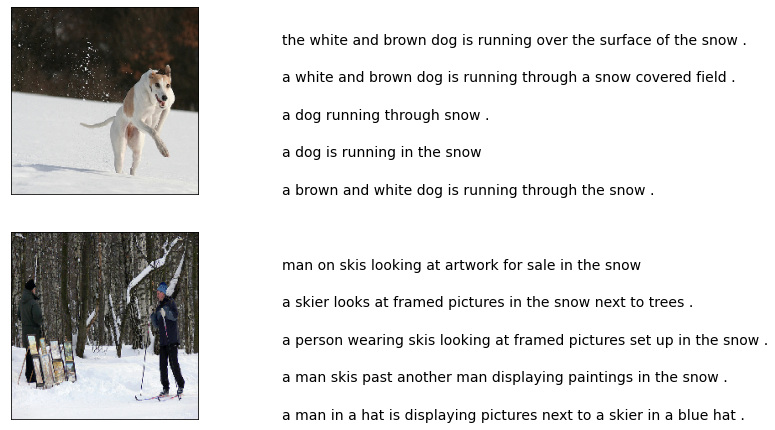

In [12]:
uni_filenames = np.unique(data.image_name.values)

npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:12]:
    filename = image_path + jpgfnm
    captions = list(data["caption"].loc[data["image_name"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=14)
    count += 1
plt.show()

## Sample of the Data
    I sample x number of rows from the dataframe for experimentation. This will make it faster to test the subsequent steps. 
    Set sample to false, when wanting to train on the entire dataset. 

In [13]:
sample = True
num_examples = 64
if sample:
    data_shuffle = data.sample(frac=1)
    df = data_shuffle[:num_examples].copy()
else:
    df = data

## Preprocessing

In [16]:
import string
from sklearn.utils import shuffle

In [ ]:
vocabulary = []
for caption in df.caption.values:
    vocabulary.extend(caption.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

In [ ]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    
    return(text_len_more_than1)

def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    
    return(text_no_numeric)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    
    return(text)

for i, caption in enumerate(df.caption.values):
    newcaption = text_clean(caption)
    df["caption"].iloc[i] = newcaption
    
clean_vocabulary = []
for caption in df.caption.values:
    clean_vocabulary.extend(caption.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

    Next, we save all the captions and image paths in two lists so that we can load the images at once using the path set. We also add ‘<start>’ and ‘<end>’ tags to every caption so that the model understands the starting and end of each caption.

In [14]:
all_captions = []
for caption  in df["caption"].astype(str):
    caption = '<start> ' + caption + ' <end>'
    all_captions.append(caption)

all_image_names = []
for image_name in df["image_name"]:
    full_image_path = image_path + image_name
    all_image_names.append(full_image_path)

print(all_captions[0])
print(all_image_names[0])
print(f"len(all_image_names) : {len(all_image_names)}")
print(f"len(all_captions) : {len(all_captions)}")

<start> a person rappelling a cliff above a body of water . <end>
../data/Flickr8k_Dataset/2255338013_566127590b.jpg
len(all_image_names) : 64
len(all_captions) : 64


    The following is only needed if we're running on the entire dataset and want the number of samples to be a multiple of 
    64. Say 40000, if batch size = 64, i.e. 625 batches. To do this we define a function to limit the dataset to 40000 images and captions. Set limit to True if you wish to define a limit. 

In [17]:
def data_limiter(num, all_captions, all_image_names):
    all_captions_shuffled, image_names_shuffled = shuffle(all_captions, all_image_names, random_state=1)
    train_captions = all_captions_shuffled[:num]
    image_names = image_names_shuffled[:num]
    
    return train_captions, image_names

limit = False
limit = 40000

if limit:
    captions, image_names = data_limiter(limit, all_captions, all_image_names)
else:
    captions = all_captions
    image_names = all_image_names

print(len(all_captions), len(captions), len(all_image_names), len(image_names))

64 64 64 64


<start> a homeless man has a shopping cart full of junk . <end> ../data/Flickr8k_Dataset/3561314880_ea9a7e245f.jpg


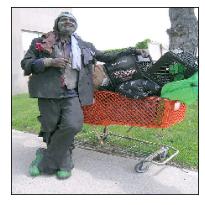

['a homeless man has a shopping cart full of junk .']


In [18]:
print(captions[5], image_names[5])

npic = 5
npix = 224
target_size = (npix,npix,3)

fig = plt.figure(figsize=(10,20))
image_load = load_img(image_names[5], target_size=target_size)
cap = list(df["caption"].loc[df["image_name"]==os.path.basename(image_names[5])].values)
ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
ax.imshow(image_load)
plt.show()
print(cap)

# Model Definition
### Image Features Using InceptionV3
    We use V3 to extract the image features from each image, hence we don't include any layers after the last conv. neural layer. The V3 model expects the images to be of size 299 x 299, so we resize them to that. The output of the last conv. layer in the model, i.e. the image features, will be 8x8x2048. 

In [19]:
from tqdm import tqdm

In [20]:
#each Keras Application expects a specific kind of input preprocessing. 
#For InceptionV3, call tf.keras.applications.inception_v3.preprocess_input on your inputs before passing them to the model.

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

#include_top = whether to include the fully-connected layer at the top, as the last layer of the network. Default to True.
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# After the last conv. layer in the V3 model the shape of the output is 8x8x2048. 
# Rest has not been included.


new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

    Next, let’s Map each image name to the function to load the image. We will pre-process each image with InceptionV3 and cache the output to disk and image features are reshaped to 64×2048.

In [21]:
encode_train = sorted(set(image_names))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
#image_dataset is an iterable of images, reads images here

image_dataset = image_dataset.map(load_image, 
                num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64) #batch(multi-element) image_dataset transformations

In [22]:
print("Shape of input images: ", image_dataset)

Shape of input images:  <BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>


    We extract the features and store them in the respective .npy files and then pass those features through the encoder.
    NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [ ]:
for img, path in tqdm(image_dataset):
    #img shape: (16, 299, 299, 3) which the V3 model expects. Format: (batch, img shape)
    batch_features = image_features_extract_model(img) #shape: (16, 8, 8, 2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3])) #shape: (16, 64, 2048)
    #batch_features.shape[0], -1 = (16, (8*8*2048)) = (16, 131072)
    #(16, 131072, batch_features[3]) = (16, 131072/2048) = (16, 64, 2048)
    
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

    Next, we tokenize the captions and build a vocabulary of all the unique words in the data. We will also limit the vocabulary size to the top 5000 words to save memory. We will replace words not in vocabulary with the token < unk >

### Tokenizing

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
top_k = 500 # Change this if necessary

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(captions)
train_seqs = tokenizer.texts_to_sequences(captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(captions)
train_seqs_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

    Next, Create training and validation sets using an 80-20 split:

In [65]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_names, train_seqs_padded, test_size=0.2, random_state=0)
print(len(img_name_train), len(img_name_val), len(cap_train), len(cap_val))

51 13 51 13


    Next, let’s create a tf.data dataset to use for training our model.

In [66]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Bert Experiments

In [26]:
from transformers import TFBertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

In [27]:
model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
model

In [3]:
model.bert.embeddings.weights[0][101]

<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([ 1.36302961e-02, -2.64904164e-02, -2.35031322e-02, -7.78762111e-03,
        8.58919881e-03, -7.66453659e-03, -9.88080073e-03,  6.01844303e-03,
        4.69211303e-03, -3.09841223e-02,  1.88834984e-02, -6.00926392e-03,
       -1.66518576e-02,  1.16844112e-02, -3.62453945e-02,  8.34820606e-03,
       -1.21121341e-03,  1.03216469e-02,  1.66918822e-02, -3.03537678e-02,
       -1.23718306e-02, -2.51732711e-02, -8.96016415e-03,  8.19942355e-03,
       -2.00110544e-02, -1.59005877e-02, -3.83943762e-03,  1.42410689e-03,
        7.04999268e-03,  1.60923810e-03, -2.77643139e-03,  9.49308742e-03,
       -2.27681026e-02,  1.93166081e-02, -1.34418225e-02, -2.37626694e-02,
       -1.46171171e-02,  9.77347139e-03, -2.24284781e-03,  3.06421630e-02,
        6.78290473e-03, -2.64705042e-03, -1.85534023e-02, -1.23629477e-02,
        7.64887501e-03, -2.54611461e-03, -3.14984620e-01,  6.37608860e-03,
        4.89142798e-02, -7.76357949e-03,  6.09193854

In [ ]:
tokenizer(['this is the first sentence', 'another setence', 'hello there'])

In [ ]:
print(tokenizer("Hello"))
tokenizer.ids_to_tokens[101], tokenizer.ids_to_tokens[102]

In [71]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', add_special_tokens=False)
model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
all_captions = ['this is the first sentence', 'another setence', 'hello there']
token_ids = tokenizer(all_captions,
                  padding=True,
                  return_tensors="tf")['input_ids']

output = model(token_ids)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
tokenizer.sep_token

'[SEP]'

## Positional Encoding

    The positional encoding uses sine and cosine functions of different frequencies. For every odd index on the input vector, create a vector using the cos function, and for every even index, create a vector using the sin function.

    Then add those vectors to their corresponding input embeddings which successfully gives the network information on the position of each vector.

In [36]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

## Multi-Head Attentionn

    Calculate the attention weights. q, k, v must have matching leading dimensions. k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v. The mask has different shapes depending on its type (padding or look ahead) but it must be broadcastable for addition.

In [37]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) #seq: (batch x seq_len) 0 where not 0 and 1 where 0.
    seq = seq[:, tf.newaxis, tf.newaxis, :]
    return seq  # (batch_size, 1, 1, seq_len) -> a list of 8 lists tf.Tensor([[[[seq_len]]] ... [[[seq_len]]]]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0) #creates lower triangular matrix of (size x size)
                                                                #mask = 1 - lower triangular matrix becomes
                                                                # an upper triangular matrix
    return mask  # (seq_len, seq_len) or (size, size)

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
            tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
            ])

## Encode-Decoder Layer

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [40]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [41]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

## Transformer

In [42]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size,max_pos_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

### Model Hyperparameters

In [43]:
# Training parameters
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [45]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [46]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,
                          target_vocab_size, max_pos_encoding=target_vocab_size,
                          rate=dropout_rate)

# Model Training

In [47]:
import time

In [48]:
def create_masks_decoder(tar):
    #target is batch x max_sent_len-1 matrice, e.g. 8x15
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) #returns the maximum of the two tensors
    
    return combined_mask

In [49]:
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1] #cuts last column off
    tar_real = tar[:, 1:] #cuts first column off
    dec_mask = create_masks_decoder(tar_inp) #creates a tensor mask of (tar_inp.shape[0], 1, tar_inp.shape[1], tar_inp.shape[1])
                                            #E.g. 8(tar_inp.shape[0] -> batch size) instances of a list of a 15x15 matrice 
    with tf.GradientTape() as tape: #backprop.GradientTape
        
        predictions, _ = transformer(inp=img_tensor, tar=tar_inp, training=True, look_ahead_mask=dec_mask)
        
        
        
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)   
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [50]:
epochs_list = []
batch_list = []
loss_list = []
accuracy_list = []

In [51]:
for epoch in range(4):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    for (batch, (img_tensor, tar)) in enumerate(dataset): #(img_tensor: image, tar: input sentence)
        train_step(img_tensor, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
            epochs_list.append(epoch)
            batch_list.append(batch)
            loss_list.append(train_loss.result())
            accuracy_list.append(train_accuracy.result())

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.6250 Accuracy 0.0010
Epoch 1 Loss 6.6250 Accuracy 0.0010
Time taken for 1 epoch: 9.483701467514038 secs

Epoch 2 Batch 0 Loss 6.6340 Accuracy 0.0000
Epoch 2 Loss 6.6340 Accuracy 0.0000
Time taken for 1 epoch: 2.096853494644165 secs

Epoch 3 Batch 0 Loss 6.6211 Accuracy 0.0010
Epoch 3 Loss 6.6211 Accuracy 0.0010
Time taken for 1 epoch: 2.3635129928588867 secs

Epoch 4 Batch 0 Loss 6.6147 Accuracy 0.0000
Epoch 4 Loss 6.6147 Accuracy 0.0000
Time taken for 1 epoch: 2.240571975708008 secs



In [52]:
import matplotlib.pyplot as plt

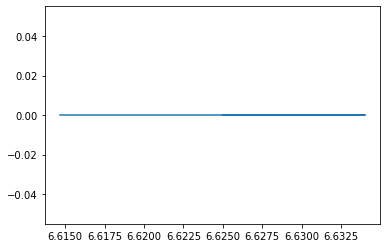

In [53]:
plt.plot(loss_list, batch_list)

# BLEU Evaluation

In [54]:
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image

In [88]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) #tokens
    result = [] #word list

    for i in range(100):
        dec_mask = create_masks_decoder(output)
        predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)

    return result,tf.squeeze(output, axis=0), attention_weights

tf.Tensor([[101]], shape=(1, 1), dtype=int32)
BLEU-1 score: 0
BLEU-2 score: 0
BLEU-3 score: 0
BLEU-4 score: 0
Real Caption: [unused8] [unused22] [unused243] [unused15] [unused244] [unused86] [unused1] [unused245] [unused13] [unused246] [unused247] [unused7]
Predicted Caption: [unused451] [unused75] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unused451] [unu

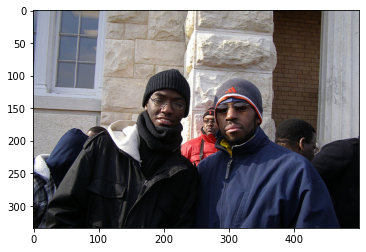

In [89]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption, result, attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)